In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
from scipy.stats import sem
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import glob as g
import re
import mdtraj as md
import seaborn as sns
import time
from io import StringIO
import os
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["figure.dpi"] = (150)


In [2]:
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd']
colors_nine = ['#1f77b4','#1f77b4','#1f77b4','#2ca02c','#2ca02c','#2ca02c','#ff7f0e','#ff7f0e','#ff7f0e']
color_palette = {
    'wat': '#1f77b4',
    'phe': '#ff7f0e',
    'bza': '#2ca02c',
    'unk1': '#d62728',
    'unk2': '#9467bd'
}

In [3]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
# Define the colors for the colormap: green, white, and orange
colors_int = [(1, 1, 1), (1, 0, 0)]

# Define the positions for the colors
positions = [0, 1]

# Create the colormap
cmap_2 = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_int)))

colors_phe = [(1, 1, 1), '#ff7f0e']
colors_bza = [(1, 1, 1), '#2ca02c']
colors_wat = [(1, 1, 1), '#1f77b4']

# Create the colormap
cmap_phe = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_phe)))
cmap_bza = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_bza)))
cmap_wat = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_wat)))


In [4]:
TZP_seq = ['TYR_1',
 'AIB_2',
 'GLU_3',
 'GLY_4',
 'THR_5',
 'PHE_6',
 'THR_7',
 'SER_8',
 'ASP_9',
 'TYR_10',
 'SER_11',
 'ILE_12',
 'AIB_13',
 'LEU_14',
 'ASP_15',
 'LYS_16',
 'ILE_17',
 'ALA_18',          
 'GLN_19',
 'LYS_20',
 'ALA_21',
 'PHE_22',          
 'VAL_23',
 'GLN_24',
 'TRP_25',
 'LEU_26',
 'ILE_27',
 'ALA_28',
 'GLY_29',
 'GLY_30',
 'PRO_31',
 'SER_32',
 'SER_33',
 'GLY_34',
 'ALA_35',
 'PRO_36',
 'PRO_37',
 'PRO_38',
 'SER_39']

# Create a DataFrame with 39 rows and Resid values from TZP_seq
resid_df = pd.DataFrame({'Resid': TZP_seq,'Resid_number': range(1, 40)})

In [5]:
resid_df

,Resid,Resid_number
0,TYR_1,1
1,AIB_2,2
2,GLU_3,3
3,GLY_4,4
4,THR_5,5
5,PHE_6,6
6,THR_7,7
7,SER_8,8
8,ASP_9,9
9,TYR_10,10


In [6]:
#path where the simulations are:
#path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped'
#path = '/lrlhps/users/l034064/TZP/Pep706/Tri_Lys20_neutral_250ns_20x'
path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'
folder = ['desmond_md_job_bza_merged_water', 'desmond_md_job_phe_60_merged_water']


In [7]:
mols = range(4,64)
systems = ['Bza','Phe']
res_num = 39
hb = []
hyd = []
pipi = []
picat = []
water = []
polar = []

for i,s in enumerate(folder):
    name = systems[i] 
    print(name)
    hb_aux = pd.DataFrame()
    hyd_aux = pd.DataFrame()
    polar_aux = pd.DataFrame()
    pipi_aux = pd.DataFrame()
    picat_aux = pd.DataFrame()
    water_aux = pd.DataFrame()
    
    hbond_sections = {}
    hydrophobic_sections = {}
    pi_pi_sections = {}
    pi_cat_sections = {}
    polar_sections = {}
    water_sections = {}
    metal_sections = {}
    for c in mols:
#        print(c)
        # Open the file and read line by line
        file = path+'/'+ s +'/'+'prot_lig_{}-out-ProtLigandInter.csv'.format(c)
#        print(file)
        if os.path.exists(file):
            with open(file, "r") as file:
                current_section = None
                for line in file:
                    if line.startswith("#HBondResult"):
                        current_section = hbond_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif line.startswith("#HydrophobicResult"):
                        current_section = hydrophobic_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif line.startswith("#PiPiResult"):
                        current_section = pi_pi_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif line.startswith("#PiCatResult"):
                        current_section = pi_cat_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                        #PiPiResult
                        #PiCatResult
                    elif line.startswith("#PolarResult"):
                        current_section = polar_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif line.startswith("#WaterBridgeResult"):    #WaterBridgeResult
                        current_section = water_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif line.startswith("#MetalResult"):  
                        current_section = metal_sections
                        current_section["header"] = line.strip()
                        current_section["data"] = []
                    elif current_section is not None:
                        current_section["data"].append(line.strip())

        #print(hbond_sections)
        # Convert sections to DataFrames
        hbond_df = pd.read_csv(StringIO("\n".join(hbond_sections["data"])))
        hbond_merged_df = pd.concat([hbond_df, hb_aux], ignore_index=True)
        hb_aux = hbond_merged_df

        hydrophobic_df = pd.read_csv(StringIO("\n".join(hydrophobic_sections["data"])))
        hyd_merged_df = pd.concat([hydrophobic_df, hyd_aux], ignore_index=True)
        hyd_aux = hyd_merged_df

        polar_df = pd.read_csv(StringIO("\n".join(polar_sections["data"])))
        polar_merged_df = pd.concat([polar_df, polar_aux], ignore_index=True)
        polar_aux = polar_merged_df
        
        pipi_df = pd.read_csv(StringIO("\n".join(pi_pi_sections["data"])))
        pipi_merged_df = pd.concat([pipi_df, pipi_aux], ignore_index=True)
        pipi_aux = pipi_merged_df

        picat_df = pd.read_csv(StringIO("\n".join(pi_cat_sections["data"])))
        picat_merged_df = pd.concat([picat_df, picat_aux], ignore_index=True)
        picat_aux = picat_merged_df
        
        water_df = pd.read_csv(StringIO("\n".join(water_sections["data"])))
        water_merged_df = pd.concat([water_df, water_aux], ignore_index=True)
        water_aux = water_merged_df
        
        #MetalResult
        
        file = path+'/'+ s +'/'+'prot_lig_{}-out-ProtLigandInter.csv'.format(c+1)
        if os.path.exists(file):
            hbond_sections = {}
            hydrophobic_sections = {}
            pi_pi_sections = {}
            pi_cat_sections = {}
            polar_sections = {}
            water_sections = {}
            metal_sections = {}
        
    hb.append(hbond_merged_df) 
    hyd.append(hyd_merged_df) 
    polar.append(polar_merged_df)
    pipi.append(pipi_merged_df) 
    picat.append(picat_merged_df) 
    water.append(water_merged_df) 

Bza
Phe


In [8]:
water[1]

,Residue/Ligand Interaction Name,Backbone/Side Chain,Fragment Atom #,Atom Name,Atoms #,Total Number,Relative Occurence (%)
0,C:ASP_15:S:L-FRAG_0,S,"2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833...",O1,2832,27,0.67
1,B:GLN_24:S:L-FRAG_0,S,"2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833...",H2838,2838,23,0.57
2,C:THR_7:S:L-FRAG_0,S,"2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833...",H2838,2838,18,0.45
3,B:GLU_3:S:L-FRAG_0,S,"2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833...",H2838,2838,12,0.30
4,C:AIB_2:B:L-FRAG_0,B,"2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833...",O1,2832,14,0.35
...,...,...,...,...,...,...,...
6503,A:PRO_37:B:L-FRAG_0,B,"2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066...",H2071,2071,1,0.02
6504,B:LEU_26:B:L-FRAG_0,B,"2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066...",O1,2065,2,0.05
6505,A:TYR_10:B:L-FRAG_0,B,"2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066...",H2071,2071,1,0.02
6506,A:ASP_9:B:L-FRAG_0,B,"2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066...",H2071,2071,1,0.02


In [9]:
resid_df

,Resid,Resid_number
0,TYR_1,1
1,AIB_2,2
2,GLU_3,3
3,GLY_4,4
4,THR_5,5
5,PHE_6,6
6,THR_7,7
7,SER_8,8
8,ASP_9,9
9,TYR_10,10


In [10]:
def filter_int(df_a,df_b,df_c,resid_df):
    # Filter rows where Resid_chain is 'A'
    # Group by Resid and FA and sum the values of Relative Occurrence (%)
    df_a_grouped = df_a.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_b_grouped = df_b.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_c_grouped = df_c.groupby(['Resid']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
               
    # Extract numerical part from "Resid" string and convert to integer
    df_a_grouped['Resid_number'] = df_a_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_b_grouped['Resid_number'] = df_b_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_c_grouped['Resid_number'] = df_c_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    
    # Merge resid_df with your original DataFrame on 'Resid' using a left join to keep all Resid values
    merged_df_A = pd.merge(resid_df, df_a_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_B = pd.merge(resid_df, df_b_grouped, on=['Resid', 'Resid_number'], how='left')
    merged_df_C = pd.merge(resid_df, df_c_grouped, on=['Resid', 'Resid_number'], how='left')
    
    # Fill missing values with 0 for 'Relative Occurrence (%)'
    merged_df_A['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_B['Relative Occurence (%)'].fillna(0, inplace=True)
    merged_df_C['Relative Occurence (%)'].fillna(0, inplace=True)

    # Reorder columns if needed
    merged_df_A = merged_df_A[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_B = merged_df_B[['Resid', 'Relative Occurence (%)', 'Resid_number']]
    merged_df_C = merged_df_C[['Resid', 'Relative Occurence (%)', 'Resid_number']]

    # Sort the DataFrame by "Resid_number"
    df_sorted_A = merged_df_A.sort_values('Resid_number')
    df_sorted_B = merged_df_B.sort_values('Resid_number')
    df_sorted_C = merged_df_C.sort_values('Resid_number')
    # Filter df_a_grouped by occurrence higher than 5
    df_filtered_A = df_sorted_A[df_sorted_A['Relative Occurence (%)'] >= 0.0]
    df_filtered_B = df_sorted_B[df_sorted_B['Relative Occurence (%)'] >= 0.0]
    df_filtered_C = df_sorted_C[df_sorted_C['Relative Occurence (%)'] >= 0.0]

    df_filtered_A.reset_index(drop=True, inplace=True)
    df_filtered_B.reset_index(drop=True, inplace=True)
    df_filtered_C.reset_index(drop=True, inplace=True)
    return(df_filtered_A,df_filtered_B,df_filtered_C)

In [11]:
#picat_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)

In [12]:
hb_final = []
hyd_final = []
polar_final = []
pipi_final = []
picat_final = []
water_final = []
for i in range(len(systems)):
    hbond_df = hb[i]
    hyd_df = hyd[i]
    polar_df = polar[i]
    pipi_df = pipi[i]
    picat_df = picat[i]
    water_df = water[i]
    #HBOND    
    hbond_df[['Resid','Resid_chain', 'Lig']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
    df_a = hbond_df[hbond_df['Resid_chain'] == 'A']
    df_b = hbond_df[hbond_df['Resid_chain'] == 'B']
    df_c = hbond_df[hbond_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    hb_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #HYDROPHOBIC
    hyd_df[['Resid','Resid_chain', 'Lig']] = hyd_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
    df_a = hyd_df[hyd_df['Resid_chain'] == 'A']
    df_b = hyd_df[hyd_df['Resid_chain'] == 'B']
    df_c = hyd_df[hyd_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    hyd_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #POLAR
#    polar_df = polar[i]
#    polar_df[['Resid','Resid_chain', 'FA']] = polar_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
#    df_a = polar_df[polar_df['Resid_chain'] == 'A']
#    df_b = polar_df[polar_df['Resid_chain'] == 'B']
#    df_c = polar_df[polar_df['Resid_chain'] == 'C']
 
#    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)
#    polar_final.append([df_filtered_A,df_filtered_B,df_filtered_C])

    #PIPI
    pipi_df[['Resid','Resid_chain', 'Lig']] = pipi_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
    df_a = pipi_df[pipi_df['Resid_chain'] == 'A']
    df_b = pipi_df[pipi_df['Resid_chain'] == 'B']
    df_c = pipi_df[pipi_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    pipi_final.append([df_filtered_A,df_filtered_B,df_filtered_C])
    
    #PICAT
    picat_df[['Resid','Resid_chain', 'Lig']] = picat_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
    df_a = picat_df[picat_df['Resid_chain'] == 'A']
    df_b = picat_df[picat_df['Resid_chain'] == 'B']
    df_c = picat_df[picat_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    picat_final.append([df_filtered_A,df_filtered_B,df_filtered_C])    
    
    #WATER
    water_df[['Resid','Resid_chain', 'Lig']] = water_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
    df_a = water_df[water_df['Resid_chain'] == 'A']
    df_b = water_df[water_df['Resid_chain'] == 'B']
    df_c = water_df[water_df['Resid_chain'] == 'C']
 
    df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c,resid_df)
    water_final.append([df_filtered_A,df_filtered_B,df_filtered_C])    
    
#    hyd_df = hyd_merged_df
#    hyd_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]

/node/scratch/137066619.1.all.normal.q/ipykernel_12442/2105736920.py:15: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hbond_df[['Resid','Resid_chain', 'Lig']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
/node/scratch/137066619.1.all.normal.q/ipykernel_12442/2105736920.py:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hyd_df[['Resid','Resid_chain', 'Lig']] = hyd_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 2]]
/node/scratch/137066619.1.all.normal.q/ipykernel_12442/2105736920.py:43: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  pipi_df[['Resid','Resid_chain', 'Lig']] = pipi_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0,

In [89]:
water_final[0][0]

,Resid,Relative Occurence (%),Resid_number
0,TYR_1,7.01,1
1,AIB_2,1.70,2
2,GLU_3,6.39,3
3,GLY_4,0.95,4
4,THR_5,1.77,5
5,PHE_6,0.97,6
6,THR_7,4.86,7
7,SER_8,1.89,8
8,ASP_9,12.96,9
9,TYR_10,5.72,10


In [91]:
combined_df

,Resid,Relative Occurence (%),Resid_number
0,TYR_1,4.85,1
1,AIB_2,1.10,2
2,GLU_3,3.85,3
3,GLY_4,0.79,4
4,THR_5,1.76,5
...,...,...,...
190,ALA_35,1.34,35
191,PRO_36,3.04,36
192,PRO_37,2.83,37
193,PRO_38,2.32,38


In [13]:
chains = ['A','B','C']
combined_df = []
for i,s in enumerate(systems):
    for j,c in enumerate(chains):
        df1 = hb_final[i][j]
        df2 = hyd_final[i][j]
        df3 = pipi_final[i][j]
        df4 = picat_final[i][j]
        df5 = water_final[i][j]
        df1['Int.'] = 'Hbond'
        df2['Int.'] = 'Hydrophobic'
        df3['Int.'] = 'Pi-Pi'
        df4['Int.'] = 'Pi_Cat'
        df5['Int.'] = 'Water Bridge'
        
        df1['Sys'] = s
        df2['Sys'] = s
        df3['Sys'] = s
        df4['Sys'] = s
        df5['Sys'] = s
        
        
        df1['Chain'] = c
        df2['Chain'] = c
        df3['Chain'] = c
        df4['Chain'] = c
        df5['Chain'] = c
        
        combined_df.append(pd.concat([df1, df2, df3, df4, df5]))

# Combine all DataFrames into a single DataFrame
final_combined_df = pd.concat(combined_df,ignore_index=True)

In [16]:
final_df = final_combined_df

In [17]:
final_df['Relative Occurence (%)'].max()

25.53

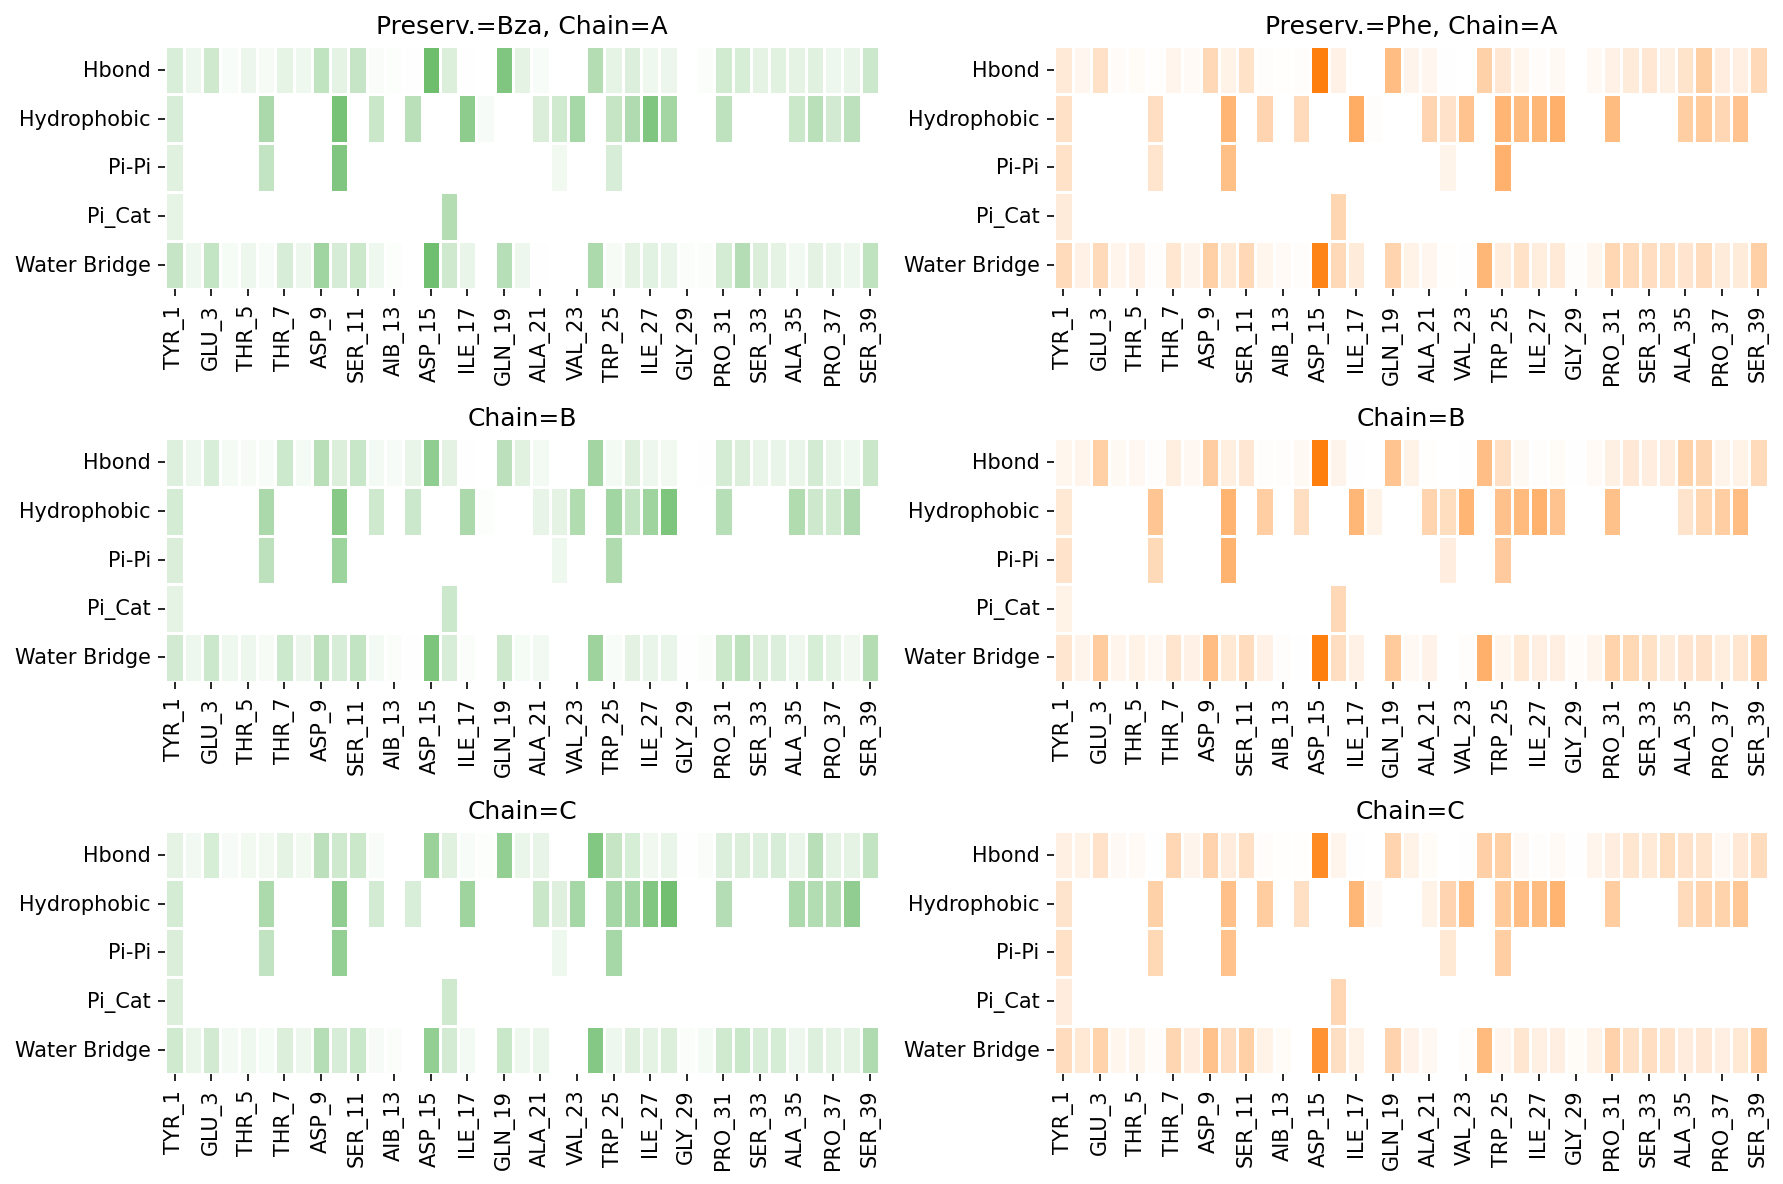

In [33]:
# Filter the DataFrame for rows where 'Sys' is 'Bza' and 'Chain' is 'A'
vmax = 25
vmin = 0


# Get unique values in the 'Int.' column
unique_int_values = final_df['Int.'].unique()
unique_resid = final_df['Resid'].unique()

# Define the combinations of 'Sys', 'Chain', and 'Int.' values
sys_values = ['Bza', 'Phe']
chain_values = ['A', 'B', 'C']

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Iterate over combinations of 'Sys', 'Chain', and 'Int.' values
for i, sys in enumerate(sys_values):
    for j, chain in enumerate(chain_values):
        # Filter the DataFrame for the current combination of 'Sys' and 'Chain'
        filtered_df = final_df[(final_df['Sys'] == sys) & (final_df['Chain'] == chain)]
        
        # Filter the DataFrame for the current 'Int.' value and pivot the data
        for k, int_value in enumerate(unique_int_values):
            heatmap_data = filtered_df.pivot(index='Int.', columns='Resid', values='Relative Occurence (%)')
            if sys == 'Bza':
                cmap = cmap_bza
            else:
                cmap = cmap_phe
            # Plot the heatmap
            heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap, linewidths=0.5, ax=axs[j, i], cbar=False,vmin=vmin, vmax=vmax)
            heatmap.set_xlabel('')
            heatmap.set_ylabel('')
            if chain == 'A':
                heatmap.set_title(f'Preserv.={sys}, Chain={chain}')
            else:
                heatmap.set_title(f'Chain={chain}')

# Add colorbar to the last plot
#

plt.tight_layout()
plt.show()

In [327]:
filtered_df 

,Resid,Relative Occurence (%),Resid_number,Int.,Sys,Chain
585,TYR_1,4.08,1,Hbond,Phe,A
586,AIB_2,1.70,2,Hbond,Phe,A
587,GLU_3,5.81,3,Hbond,Phe,A
588,GLY_4,0.69,4,Hbond,Phe,A
589,THR_5,0.82,5,Hbond,Phe,A
...,...,...,...,...,...,...
1165,ALA_35,3.69,35,Water Bridge,Phe,C
1166,PRO_36,4.29,36,Water Bridge,Phe,C
1167,PRO_37,3.10,37,Water Bridge,Phe,C
1168,PRO_38,4.50,38,Water Bridge,Phe,C


In [335]:
filtered_df 

,Int.,Resid,Relative Occurence (%),Resid_number
0,Hbond,AIB_13,0.556667,13.0
1,Hbond,AIB_2,2.023333,2.0
2,Hbond,ALA_18,0.183333,18.0
3,Hbond,ALA_21,1.726667,21.0
4,Hbond,ALA_28,2.233333,28.0
...,...,...,...,...
190,Water Bridge,THR_7,4.960000,7.0
191,Water Bridge,TRP_25,1.370000,25.0
192,Water Bridge,TYR_1,5.996667,1.0
193,Water Bridge,TYR_10,4.753333,10.0


In [343]:
chain_a_resid_df

,Resid,Relative Occurence (%),Resid_number,Int.,Sys,Chain
0,TYR_1,4.53,1,Hbond,Bza,A
39,TYR_1,4.76,1,Hydrophobic,Bza,A
78,TYR_1,3.68,1,Pi-Pi,Bza,A
117,TYR_1,3.01,1,Pi_Cat,Bza,A
156,TYR_1,6.82,1,Water Bridge,Bza,A
585,TYR_1,4.08,1,Hbond,Phe,A
624,TYR_1,5.77,1,Hydrophobic,Phe,A
663,TYR_1,5.73,1,Pi-Pi,Phe,A
702,TYR_1,3.94,1,Pi_Cat,Phe,A
741,TYR_1,7.11,1,Water Bridge,Phe,A


In [350]:
chain_c_int_df

,Resid,Relative Occurence (%),Resid_number,Int.,Sys,Chain
390,TYR_1,3.06,1,Hbond,Bza,C
391,AIB_2,1.63,2,Hbond,Bza,C
392,GLU_3,4.87,3,Hbond,Bza,C
393,GLY_4,1.04,4,Hbond,Bza,C
394,THR_5,1.75,5,Hbond,Bza,C
...,...,...,...,...,...,...
1009,ALA_35,5.62,35,Hbond,Phe,C
1010,PRO_36,5.10,36,Hbond,Phe,C
1011,PRO_37,1.37,37,Hbond,Phe,C
1012,PRO_38,4.23,38,Hbond,Phe,C


In [354]:
chain_a_int_df

,Resid,Relative Occurence (%),Resid_number,Int.,Sys,Chain
585,TYR_1,4.08,1,Hbond,Phe,A
586,AIB_2,1.70,2,Hbond,Phe,A
587,GLU_3,5.81,3,Hbond,Phe,A
588,GLY_4,0.69,4,Hbond,Phe,A
589,THR_5,0.82,5,Hbond,Phe,A
590,PHE_6,0.21,6,Hbond,Phe,A
591,THR_7,2.04,7,Hbond,Phe,A
592,SER_8,1.05,8,Hbond,Phe,A
593,ASP_9,7.50,9,Hbond,Phe,A
594,TYR_10,2.42,10,Hbond,Phe,A


In [355]:
chain_a_pivot

,Resid,AIB_13,AIB_2,ALA_18,ALA_21,ALA_28,ALA_35,ASP_15,ASP_9,GLN_19,GLN_24,...,SER_32,SER_33,SER_39,SER_8,THR_5,THR_7,TRP_25,TYR_1,TYR_10,VAL_23
Resid,Int.,,,,,,,,,,,,,,,,,,,,,
AIB_13,Hbond,0.25,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
AIB_2,Hbond,0.00,1.7,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ALA_18,Hbond,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ALA_21,Hbond,0.00,0.0,0.0,1.73,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ALA_28,Hbond,0.00,0.0,0.0,0.00,1.19,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ALA_35,Hbond,0.00,0.0,0.0,0.00,0.00,5.33,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ASP_15,Hbond,0.00,0.0,0.0,0.00,0.00,0.00,25.13,0.0,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
ASP_9,Hbond,0.00,0.0,0.0,0.00,0.00,0.00,0.00,7.5,0.00,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
GLN_19,Hbond,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,12.87,0.00,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [34]:
# Assuming final_df is your DataFrame

# Calculate the average 'Relative Occurrence (%)' for 'Whole pep.'
whole_pep_avg = final_df.groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
whole_pep_avg.rename(columns={'Relative Occurence (%)': 'Whole pep.'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 1-20
resid_1_to_20_avg = final_df[final_df['Resid_number'].between(1, 20)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_1_to_20_avg.rename(columns={'Relative Occurence (%)': 'Resid. 1-20'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 21-39
resid_21_to_39_avg = final_df[final_df['Resid_number'].between(21, 39)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_21_to_39_avg.rename(columns={'Relative Occurence (%)': 'Resid. 21-39'}, inplace=True)

# Merge the average values into a new DataFrame
new_df = whole_pep_avg.merge(resid_1_to_20_avg, on=['Int.', 'Sys'], how='outer').merge(resid_21_to_39_avg, on=['Int.', 'Sys'], how='outer')

# Print or further process the new_df DataFrame
print(new_df)

           Int.  Sys  Whole pep.  Resid. 1-20  Resid. 21-39
0         Hbond  Bza      417.40       227.77        189.63
1         Hbond  Phe      431.09       235.98        195.11
2   Hydrophobic  Bza      481.51       160.29        321.22
3   Hydrophobic  Phe      561.84       178.50        383.34
4         Pi-Pi  Bza      104.77        74.37         30.40
5         Pi-Pi  Phe      121.26        76.34         44.92
6        Pi_Cat  Bza       31.53        31.53          0.00
7        Pi_Cat  Phe       33.39        33.39          0.00
8  Water Bridge  Bza      442.60       239.04        203.56
9  Water Bridge  Phe      574.00       310.74        263.26


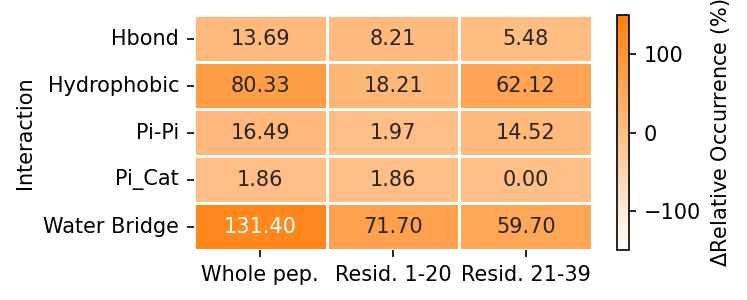

In [35]:
vmax = 150
vmin = -150

# Get unique values in the 'Int.' column
unique_int_values = new_df['Int.'].unique()

# Initialize an empty DataFrame to store the differences
difference_df = pd.DataFrame(index=unique_int_values)

# Filter the DataFrame for 'Phe' and 'Bza' interactions
for int_value in unique_int_values:
    phe_values = new_df[(new_df['Sys'] == 'Phe') & (new_df['Int.'] == int_value)]
    bza_values = new_df[(new_df['Sys'] == 'Bza') & (new_df['Int.'] == int_value)]
    
    # Calculate the differences between the columns for 'Phe' and 'Bza'
    difference_cols = ['Whole pep.', 'Resid. 1-20', 'Resid. 21-39']
    for col in difference_cols:
        difference_col = col
        difference_df.loc[int_value, difference_col] = phe_values[col].values - bza_values[col].values

# Plot the heatmap
plt.figure(figsize=(5, 2.1))
heatmap = sns.heatmap(difference_df, cmap=cmap, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False, annot=True, fmt=".2f")

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'$\Delta$Relative Occurrence (%)')

plt.tight_layout()
plt.show()

In [36]:
 new_aux

NameError: name 'new_aux' is not defined

In [21]:
var = final_combined_df.groupby(['Sys', 'Int.','Resid'])['Relative Occurence (%)'].var()

var = var.reset_index()

In [22]:
var = var.groupby(['Sys', 'Int.'])['Relative Occurence (%)'].mean()
var = var.reset_index()

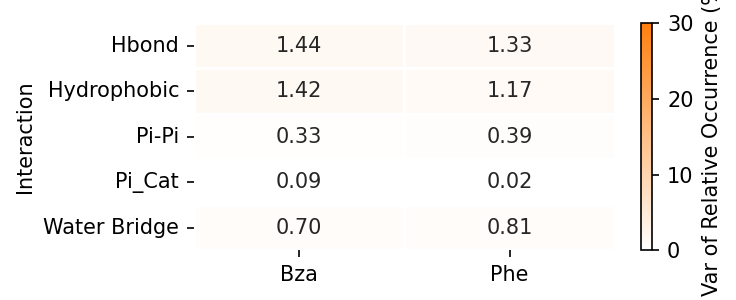

In [37]:
vmax = 30
vmin = 0

# Get unique values in the 'Int.' column
unique_int_values = new_df['Int.'].unique()

# Plot the heatmap
plt.figure(figsize=(5, 2.1))
heatmap_data = var.pivot(index='Int.', columns='Sys', values='Relative Occurence (%)')
heatmap = sns.heatmap(heatmap_data, cmap=cmap, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False, annot=True, fmt=".2f")

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label('Var of Relative Occurrence (%)')

plt.tight_layout()
plt.show()

In [38]:
whole_pep_avg = var.groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
whole_pep_avg.rename(columns={'Relative Occurence (%)': 'Whole pep.'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 1-20
resid_1_to_20_avg = final_df[final_df['Resid_number'].between(1, 20)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_1_to_20_avg.rename(columns={'Relative Occurence (%)': 'Resid. 1-20'}, inplace=True)

# Calculate the average 'Relative Occurrence (%)' for Resid_number range 21-39
resid_21_to_39_avg = final_df[final_df['Resid_number'].between(21, 39)].groupby(['Int.', 'Sys'])['Relative Occurence (%)'].sum().reset_index()
resid_21_to_39_avg.rename(columns={'Relative Occurence (%)': 'Resid. 21-39'}, inplace=True)

# Merge the average values into a new DataFrame
new_df = whole_pep_avg.merge(resid_1_to_20_avg, on=['Int.', 'Sys'], how='outer').merge(resid_21_to_39_avg, on=['Int.', 'Sys'], how='outer')

# Print or further process the new_df DataFrame
print(new_df)

           Int.  Sys  Whole pep.  Resid. 1-20  Resid. 21-39
0         Hbond  Bza    1.438468       227.77        189.63
1         Hbond  Phe    1.326909       235.98        195.11
2   Hydrophobic  Bza    1.418809       160.29        321.22
3   Hydrophobic  Phe    1.169133       178.50        383.34
4         Pi-Pi  Bza    0.331555        74.37         30.40
5         Pi-Pi  Phe    0.388469        76.34         44.92
6        Pi_Cat  Bza    0.087256        31.53          0.00
7        Pi_Cat  Phe    0.016407        33.39          0.00
8  Water Bridge  Bza    0.698298       239.04        203.56
9  Water Bridge  Phe    0.813722       310.74        263.26


In [39]:
vmax = 10
vmin = 0

var_2 = var[var['Sys']=='Bza']
print(var_2['Relative Occurence (%)'].max())
heatmap_data = var_2.pivot(index='Int.', columns='Resid', values='Relative Occurence (%)')

# Create the heatmap
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap_bza, linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False)

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=-vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_bza, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'Var of Relative Occurrence (%)')

plt.tight_layout()
plt.show()

1.4384675213675213


KeyError: 'Resid'

In [40]:
# Calculate the mean of 'Relative Occurrence (%)' for each unique combination of 'Sys' and 'Int.'
means_per_resid = final_combined_df.groupby(['Sys','Resid', 'Int.','Resid_number'])['Relative Occurence (%)'].mean()
# Convert the result to a DataFrame
mean_occurrence_df = means_per_resid.reset_index()

In [41]:
mean_occurrence_df

,Sys,Resid,Int.,Resid_number,Relative Occurence (%)
0,Bza,AIB_13,Hbond,13,0.556667
1,Bza,AIB_13,Hydrophobic,13,0.000000
2,Bza,AIB_13,Pi-Pi,13,0.000000
3,Bza,AIB_13,Pi_Cat,13,0.000000
4,Bza,AIB_13,Water Bridge,13,0.560000
...,...,...,...,...,...
385,Phe,VAL_23,Hbond,23,0.080000
386,Phe,VAL_23,Hydrophobic,23,12.916667
387,Phe,VAL_23,Pi-Pi,23,0.000000
388,Phe,VAL_23,Pi_Cat,23,0.000000


In [42]:
# Pivot the DataFrame
pivot_df = mean_occurrence_df.groupby(['Resid', 'Int.', 'Resid_number', 'Sys'])['Relative Occurence (%)'].mean().unstack()

# Calculate the difference between 'phe' and 'bza' systems for each 'Resid'
pivot_df['difference'] = pivot_df['Phe'] - pivot_df['Bza']

# Reset index to convert the result to a DataFrame
difference_df = pivot_df.reset_index()

In [43]:
difference_df

Sys,Resid,Int.,Resid_number,Bza,Phe,difference
0,AIB_13,Hbond,13,0.556667,0.276667,-0.280000
1,AIB_13,Hydrophobic,13,0.000000,0.000000,0.000000
2,AIB_13,Pi-Pi,13,0.000000,0.000000,0.000000
3,AIB_13,Pi_Cat,13,0.000000,0.000000,0.000000
4,AIB_13,Water Bridge,13,0.560000,0.726667,0.166667
...,...,...,...,...,...,...
190,VAL_23,Hbond,23,0.006667,0.080000,0.073333
191,VAL_23,Hydrophobic,23,10.136667,12.916667,2.780000
192,VAL_23,Pi-Pi,23,0.000000,0.000000,0.000000
193,VAL_23,Pi_Cat,23,0.000000,0.000000,0.000000


In [44]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
# Define the colors for the colormap: green, white, and orange
color_map = ['#2ca02c', (1, 1, 1) ,'#ff7f0e']

# Define the positions for the colors
positions = [0, 0.5, 1]

# Create the colormap
cmap = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, color_map)))


In [45]:
difference_df['difference'].min()

-2.880000000000001

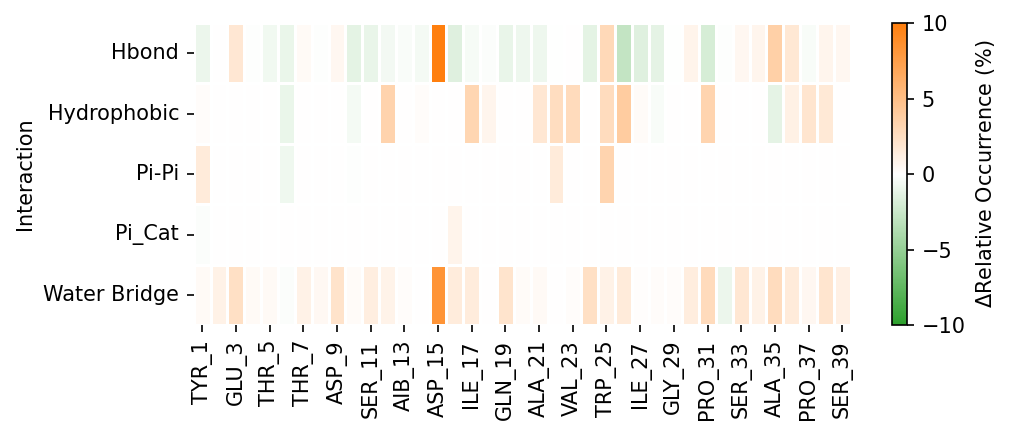

In [46]:
heatmap_data = difference_df.pivot(index='Int.', columns='Resid', values='difference')

# Create the heatmap
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(heatmap_data[unique_resid], cmap=cmap, linewidths=0.5, vmin=-10, vmax=10, cbar=False)

#plt.title('Relative Occurrence (%)')
plt.xlabel('')
plt.ylabel('Interaction')

# Customize the colorbar label
norm = Normalize(vmin=-10, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=heatmap).set_label(r'$\Delta$Relative Occurrence (%)')

plt.tight_layout()
plt.show()

In [47]:
final_df = final_combined_df
# Filter the DataFrame for 'Sys' is 'Phe' and 'Chain' is 'B'
filtered_df_b = final_df[(final_df['Sys'] == 'Phe') & (final_df['Chain'] == 'B')]

# Calculate the average for this group
average_b = filtered_df_b.groupby(['Resid', 'Int.'])['Relative Occurence (%)'].mean()

# Filter the DataFrame for 'Sys' is 'Phe' and 'Chain' is 'A' or 'C'
filtered_df_ac = final_df[(final_df['Sys'] == 'Phe') & (final_df['Chain'].isin(['A', 'C']))]

# Calculate the average for this group
average_ac = filtered_df_ac.groupby(['Resid', 'Int.'])['Relative Occurence (%)'].mean()

# Calculate the difference between the averages
difference_df = average_ac - average_b

# Reset index to convert the result to a DataFrame
difference_df = difference_df.reset_index()

difference_df

,Resid,Int.,Relative Occurence (%)
0,AIB_13,Hbond,-0.050
1,AIB_13,Hydrophobic,0.000
2,AIB_13,Pi-Pi,0.000
3,AIB_13,Pi_Cat,0.000
4,AIB_13,Water Bridge,0.535
...,...,...,...
190,VAL_23,Hbond,-0.075
191,VAL_23,Hydrophobic,-2.330
192,VAL_23,Pi-Pi,0.000
193,VAL_23,Pi_Cat,0.000


In [48]:
 difference_df['Relative Occurence (%)'].min()

-3.6049999999999986

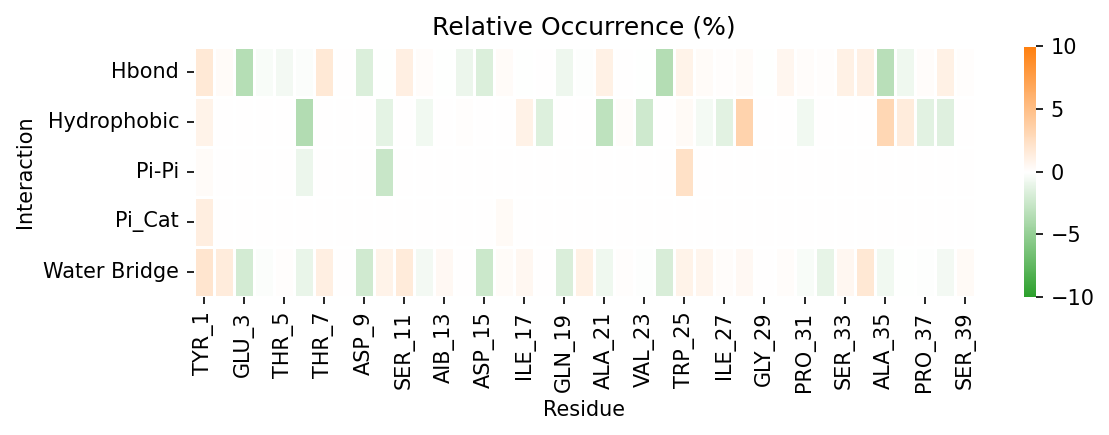

In [49]:
# Reshape the DataFrame for heatmap
heatmap_data = difference_df.pivot(index='Int.', columns='Resid', values='Relative Occurence (%)')


# Create the heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(heatmap_data[unique_resid], cmap=cmap, linewidths=0.5, vmin =-10, vmax = 10)

plt.title('Relative Occurrence (%)')
plt.xlabel('Residue')
plt.ylabel('Interaction')
plt.tight_layout()
plt.show()
plt.show()

In [50]:
categories = ['Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Define the ranges of residues
Nter = range(1, 21)
Cter = range(21, 40)

sums_all = []
sums_Nter = []
sums_Cter = []

sem_all = []
sem_Nter = []
sem_Cter = []

chain_tick = []
for i in range(len(system)):
    for j, c in enumerate(chains):
        df_hb = hb_final[i][j]
        sums_all.append(df_hb['Relative Occurence (%)'].sum()/res_num)
        sums_Nter.append(df_hb[df_hb['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sum()/len(Nter))
        sums_Cter.append(df_hb[df_hb['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sum()/len(Cter))
        
        sem_all.append(df_hb['Relative Occurence (%)'].sem()/4)
        sem_Nter.append(df[df['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sem()/3)
        sem_Cter.append(df[df['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sem()/2)
        
        chain_tick.append(c)
# Plot the sums using a bar plot
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

axes[0].bar(range(1, 10), sums_all, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_all,capsize=3)
axes[0].set_xlabel('')
axes[0].set_title('Whole Pep')
axes[0].set_ylim(2,5.5)
axes[0].set_ylabel('<FA/Pep Hbond Occurences>')
axes[0].set_xticks(range(1, 10),categories, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(range(1, 10), sums_Nter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Nter,capsize=3)
axes[1].set_xlabel('')
axes[1].set_title('Res. 1-20')
axes[1].set_ylim(2,5.5)
axes[1].set_xticks(range(1, 10),categories, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].bar(range(1, 10), sums_Cter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Cter,capsize=3)
axes[2].set_xlabel('')
axes[2].set_title('Res. 21-39')
axes[2].set_ylim(2,5.5)
axes[2].set_xticks(range(1, 10),categories, rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


NameError: name 'system' is not defined

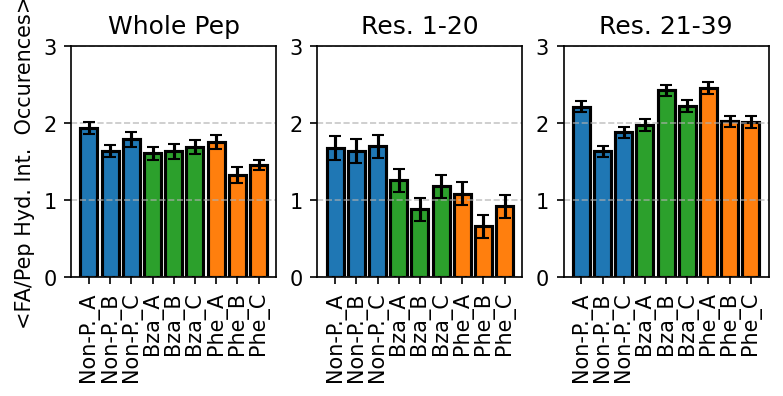

In [120]:
categories = ['Non-P._A','Non-P._B','Non-P._C','Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Define the ranges of residues
Nter = range(1, 21)
Cter = range(21, 40)

sums_all = []
sums_Nter = []
sums_Cter = []

sem_all = []
sem_Nter = []
sem_Cter = []

chain_tick = []
for i in range(len(system)):
    for j, c in enumerate(chains):
        df_hb = hyd_final[i][j]
        sums_all.append(df_hb['Relative Occurence (%)'].sum()/res_num)
        sums_Nter.append(df_hb[df_hb['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sum()/len(Nter))
        sums_Cter.append(df_hb[df_hb['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sum()/len(Cter))
        
        sem_all.append(df_hb['Relative Occurence (%)'].sem()/2)
        sem_Nter.append(df[df['Resid_number'].isin(Nter)]['Relative Occurence (%)'].sem()/2)
        sem_Cter.append(df[df['Resid_number'].isin(Cter)]['Relative Occurence (%)'].sem()/2)
        
        chain_tick.append(c)
# Plot the sums using a bar plot
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

axes[0].bar(range(1, 10), sums_all, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_all,capsize=3)
axes[0].set_xlabel('')
axes[0].set_title('Whole Pep')
axes[0].set_ylim(0,3)
axes[0].set_ylabel('<FA/Pep Hyd. Int.  Occurences>')
axes[0].set_xticks(range(1, 10),categories, rotation=90)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(range(1, 10), sums_Nter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Nter,capsize=3)
axes[1].set_xlabel('')
axes[1].set_title('Res. 1-20')
axes[1].set_ylim(0,3.0)
axes[1].set_xticks(range(1, 10),categories, rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].bar(range(1, 10), sums_Cter, color=colors_nine,edgecolor='black', linewidth=1.5,yerr=sem_Cter,capsize=3)
axes[2].set_xlabel('')
axes[2].set_title('Res. 21-39')
axes[2].set_ylim(0,3.0)
axes[2].set_xticks(range(1, 10),categories, rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [130]:
df1

,Resid,FA,Relative Occurence (%),Resid_number
0,TYR_1,L-FRAG_0,1.82,1
1,TYR_1,L-FRAG_10,0.46,1
2,TYR_1,L-FRAG_12,0.46,1
3,TYR_1,L-FRAG_8,0.33,1
4,TYR_1,L-FRAG_6,0.24,1
...,...,...,...,...
65,PRO_37,L-FRAG_8,0.40,37
66,PRO_37,L-FRAG_6,0.26,37
67,PRO_38,L-FRAG_8,0.23,38
68,PRO_38,L-FRAG_2,0.40,38


In [225]:
df1 = hb_final[2][0]
df2 = hb_final[2][1]
df3 = hb_final[2][2]

# Merge df1 and df2 on 'FA', 'Resid', and 'Resid_number' columns with an outer join
merged_df1 = pd.merge(df1, df2, on=['FA', 'Resid', 'Resid_number'], how='outer', suffixes=('_df1', '_df2'))

# Merge the result with df3 on 'FA', 'Resid', and 'Resid_number' columns with an outer join
merged_df = pd.merge(merged_df1, df3, on=['FA', 'Resid', 'Resid_number'], how='outer', suffixes=('_merged', '_df3'))

# Fill missing values with zero
merged_df['Relative Occurence (%)_df1'].fillna(0, inplace=True)
merged_df['Relative Occurence (%)_df2'].fillna(0, inplace=True)
merged_df['Relative Occurence (%)'].fillna(0, inplace=True)

# Calculate the differences between DataFrame pairs
merged_df['Occurrence Difference'] = merged_df['Relative Occurence (%)_df2']# - (merged_df['Relative Occurence (%)_df1']+merged_df['Relative Occurence (%)'])/2
filtered_df = merged_df[(merged_df['Occurrence Difference'] > 1) | (merged_df['Occurrence Difference'] < -1)]
# Display the resulting DataFrame
#print(merged_df[['FA', 'Resid', 'Resid_number', 'Occurrence Difference_df1_df2', 'Occurrence Difference_df1_df3', 'Occurrence Difference_df2_df3']])

In [226]:
sorted_df

,Resid,FA,Relative Occurence (%)_df1,Resid_number,Relative Occurence (%)_df2,Relative Occurence (%),Occurrence Difference
1,TYR_1,L-FRAG_2,3.24,1,1.15,1.69,-1.315
6,TYR_1,L-FRAG_0,4.80,1,6.88,4.01,2.475
88,AIB_2,L-FRAG_14,0.00,2,1.39,0.00,1.390
9,GLU_3,L-FRAG_0,0.33,3,2.58,0.97,1.930
10,GLY_4,L-FRAG_0,0.26,4,2.28,0.46,1.920
13,THR_5,L-FRAG_0,0.96,5,8.15,0.51,7.415
15,THR_7,L-FRAG_0,6.82,7,2.09,2.65,-2.645
16,THR_7,L-FRAG_2,1.06,7,0.27,1.49,-1.005
114,SER_11,L-FRAG_9,0.00,11,0.00,2.25,-1.125
23,SER_11,L-FRAG_0,1.79,11,7.38,0.46,6.255


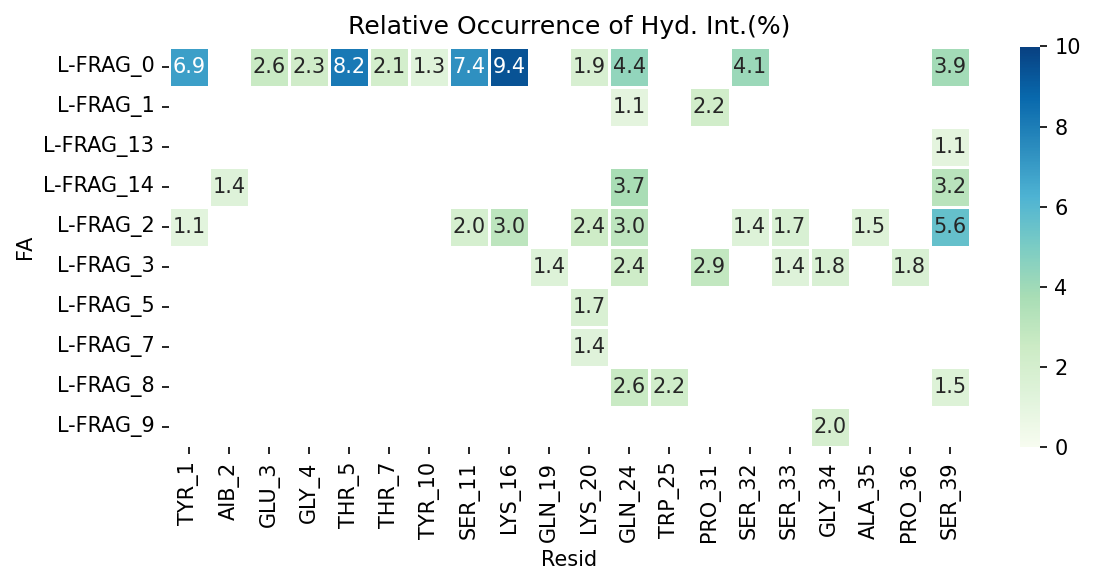

In [233]:
# Sort the DataFrame by 'Resid_number' in ascending order
sorted_df = filtered_df.sort_values(by='Resid_number')

unique_resid = sorted_df['Resid'].unique()

# Reshape the DataFrame for heatmap
heatmap_data = sorted_df.pivot(index='FA', columns='Resid', values='Occurrence Difference')



# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data[unique_resid], annot=True, fmt=".1f", linewidths=0.5,cmap='GnBu', vmin = 0, vmax = 10)

plt.title('Relative Occurrence of Hyd. Int.(%)')
plt.xlabel('Resid')
plt.ylabel('FA')
plt.tight_layout()
plt.show()

In [ ]:
#Separate by chain

df_a = hbond_df[hbond_df['Resid_chain'] == 'A']
df_b = hbond_df[hbond_df['Resid_chain'] == 'B']
df_c = hbond_df[hbond_df['Resid_chain'] == 'C']
#call function to filter 
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)

df_a = hyd_df[hyd_df['Resid_chain'] == 'A']
df_b = hyd_df[hyd_df['Resid_chain'] == 'B']
df_c = hyd_df[hyd_df['Resid_chain'] == 'C']
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)